In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


In [58]:
%matplotlib inline
plt.rcParams.update({'font.size': 22})
plt.style.use('seaborn-darkgrid')

In [41]:
raw_df = pd.read_csv('basic_movie_data.csv')
raw_df.sample(5)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget
5740,larrythecableguy,http://www.boxofficemojo.com/movies/?id=larryt...,22139,"$15,680,099",Lionsgate,"March 24, 2006",Comedy,1 hrs. 29 min.,PG-13,NaN
2073,ride,http://www.boxofficemojo.com/movies/?id=ride.htm,19316,"$5,485,295",Miramax,"March 27, 1998",Comedy,1 hrs. 40 min.,R,NaN
4060,rudoycursi,http://www.boxofficemojo.com/movies/?id=rudoyc...,20481,"$1,827,660",Sony Classics,"May 8, 2009",Foreign,1 hrs. 30 min.,R,NaN
5145,howtomakeanamericanquilt,http://www.boxofficemojo.com/movies/?id=howtom...,21971,"$23,600,020",Universal,"October 6, 1995",Romance,1 hrs. 57 min.,PG-13,NaN
1671,howtogetaheadinadvertising,http://www.boxofficemojo.com/movies/?id=howtog...,16896,"$418,053",Warner Bros.,"May 5, 1989",Comedy,1 hrs. 34 min.,R,NaN


In [43]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 10 columns):
name                    6926 non-null object
url                     6926 non-null object
file_size               6926 non-null int64
domestic_total_gross    6788 non-null object
distributor             6926 non-null object
release_date            6926 non-null object
genre                   6926 non-null object
runtime                 6875 non-null object
mpaa_rating             6926 non-null object
production_budget       2629 non-null object
dtypes: int64(1), object(9)
memory usage: 541.2+ KB


In [5]:
raw_df_subset = raw_df.dropna(subset=['production_budget','domestic_total_gross'])
raw_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 6 to 6923
Data columns (total 10 columns):
name                    2605 non-null object
url                     2605 non-null object
file_size               2605 non-null int64
domestic_total_gross    2605 non-null object
distributor             2605 non-null object
release_date            2605 non-null object
genre                   2605 non-null object
runtime                 2601 non-null object
mpaa_rating             2605 non-null object
production_budget       2605 non-null object
dtypes: int64(1), object(9)
memory usage: 223.9+ KB


In [6]:
import re
import datetime as dt

def parse_date_string(string):
    return dt.datetime.strptime(string, '%B %d, %Y').date()

def parse_runtime_string(string):
    if type(string) != str: return string
    hours, minutes = [float(re.sub(r"[^0-9.]?", "", s)) for s in string.split(' hrs. ')]
    return hours * 60 + minutes

def parse_dollar_string(string):
    if type(string) != str: return string
    unit = 1e6 if 'million' in string else 1
    if ':' in string: string = string.split(':')[0]
    parsed_string = re.sub(r"[^0-9.]?", "", string)
    n = float(parsed_string)
    if n * unit > 1e9:
        print(string)
    return n * unit

In [7]:
df = raw_df_subset.copy()
df['release_date'] = raw_df_subset.release_date.apply(parse_date_string)
df['runtime'] = raw_df_subset.runtime.apply(parse_runtime_string)
df['production_budget'] = raw_df_subset.production_budget.apply(parse_dollar_string)
df['domestic_total_gross'] = raw_df_subset.domestic_total_gross.apply(parse_dollar_string)

In [8]:
df['gross_to_budget_ratio'] = df.domestic_total_gross / df.production_budget
df['gross_minus_budget'] = df.domestic_total_gross - df.production_budget

In [9]:
df.sort_values('gross_to_budget_ratio', ascending=False).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
4348,paranormalactivity,http://www.boxofficemojo.com/movies/?id=parano...,29252,107918810.0,Paramount,2009-09-25,Horror,99.0,R,15000.0,7194.587333,107903810.0
3625,newlinehorror2015,http://www.boxofficemojo.com/movies/?id=newlin...,21824,22764410.0,Warner Bros. (New Line),2015-07-10,Horror,81.0,R,100000.0,227.644100,22664410.0
1933,clerks,http://www.boxofficemojo.com/movies/?id=clerks...,20900,3151130.0,Miramax,1994-10-19,Comedy,92.0,R,27000.0,116.708519,3124130.0
4487,napoleondynamite,http://www.boxofficemojo.com/movies/?id=napole...,26884,44540956.0,Fox Searchlight,2004-06-11,Comedy,86.0,PG,400000.0,111.352390,44140956.0
5224,once,http://www.boxofficemojo.com/movies/?id=once.htm,20173,9439923.0,Fox Searchlight,2007-05-16,Music Drama,85.0,R,150000.0,62.932820,9289923.0
2743,openwater,http://www.boxofficemojo.com/movies/?id=openwa...,25403,30610863.0,Lions Gate,2004-08-06,Horror,79.0,R,500000.0,61.221726,30110863.0
6622,devilinside,http://www.boxofficemojo.com/movies/?id=devili...,26185,53261944.0,Paramount,2012-01-06,Horror,87.0,R,1000000.0,53.261944,52261944.0
5704,saw,http://www.boxofficemojo.com/movies/?id=saw.htm,29483,55185045.0,Lions Gate,2004-10-29,Horror,100.0,R,1200000.0,45.987538,53985045.0
785,snowwhite,http://www.boxofficemojo.com/movies/?id=snowwh...,19405,66596803.0,Disney,1937-12-21,Animation,83.0,G,1499000.0,44.427487,65097803.0
3830,brothersmcmullen,http://www.boxofficemojo.com/movies/?id=brothe...,19597,10426506.0,Fox Searchlight,1995-08-11,Comedy,98.0,R,238000.0,43.808849,10188506.0


In [10]:
df.sort_values('gross_minus_budget', ascending=False).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
6418,starwars7,http://www.boxofficemojo.com/movies/?id=starwa...,53067,936662225.0,Buena Vista,2015-12-18,Sci-Fi Fantasy,136.0,PG-13,245000000.0,3.823111,691662225.0
5720,avatar,http://www.boxofficemojo.com/movies/?id=avatar...,56984,749766139.0,Fox,2009-12-18,Sci-Fi Adventure,160.0,PG-13,237000000.0,3.163570,512766139.0
6635,jurassicpark4,http://www.boxofficemojo.com/movies/?id=jurass...,45119,652270625.0,Universal,2015-06-12,Action / Adventure,124.0,PG-13,150000000.0,4.348471,502270625.0
4193,avengers11,http://www.boxofficemojo.com/movies/?id=avenge...,53870,623357910.0,Buena Vista,2012-05-04,Action / Adventure,142.0,PG-13,220000000.0,2.833445,403357910.0
4665,titanic,http://www.boxofficemojo.com/movies/?id=titani...,44670,600788188.0,Paramount,1997-12-19,Romance,194.0,PG-13,200000000.0,3.003941,400788188.0
1025,et,http://www.boxofficemojo.com/movies/?id=et.htm,37645,359197037.0,Universal,1982-06-11,Family Adventure,117.0,PG,10500000.0,34.209242,348697037.0
3253,darkknight,http://www.boxofficemojo.com/movies/?id=darkkn...,51942,533345358.0,Warner Bros.,2008-07-18,Action / Adventure,150.0,PG-13,185000000.0,2.882948,348345358.0
234,beautyandthebeast2017,http://www.boxofficemojo.com/movies/?id=beauty...,47435,504014165.0,Buena Vista,2017-03-17,Fantasy,129.0,PG,160000000.0,3.150089,344014165.0
435,starwars2016,http://www.boxofficemojo.com/movies/?id=starwa...,43675,532177324.0,Buena Vista,2016-12-16,Sci-Fi Adventure,133.0,PG-13,200000000.0,2.660887,332177324.0
5780,hungergames,http://www.boxofficemojo.com/movies/?id=hunger...,47800,408010692.0,Lionsgate,2012-03-23,Action / Adventure,142.0,PG-13,78000000.0,5.230906,330010692.0


In [11]:
df.sort_values('gross_minus_budget', ascending=True).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
2719,johncarterofmars,http://www.boxofficemojo.com/movies/?id=johnca...,28942,73078100.0,Buena Vista,2012-03-09,Sci-Fi Adventure,132.0,PG-13,250000000.0,0.292312,-176921900.0
1747,battleship,http://www.boxofficemojo.com/movies/?id=battle...,28976,65422625.0,Universal,2012-05-18,Action,131.0,PG-13,209000000.0,0.313027,-143577375.0
4402,47ronin,http://www.boxofficemojo.com/movies/?id=47roni...,23680,38362475.0,Universal,2013-12-25,Action Drama,127.0,PG-13,175000000.0,0.219214,-136637525.0
409,kingarthur2016,http://www.boxofficemojo.com/movies/?id=kingar...,25600,39175066.0,Warner Bros.,2017-05-12,Adventure,126.0,PG-13,175000000.0,0.223858,-135824934.0
932,jackthegiantkiller,http://www.boxofficemojo.com/movies/?id=jackth...,28465,65187603.0,Warner Bros. (New Line),2013-03-01,Adventure,114.0,PG-13,195000000.0,0.334295,-129812397.0
6840,jupiterascending,http://www.boxofficemojo.com/movies/?id=jupite...,25950,47387723.0,Warner Bros.,2015-02-06,Sci-Fi,127.0,PG-13,176000000.0,0.269248,-128612277.0
4785,marsneedsmoms,http://www.boxofficemojo.com/movies/?id=marsne...,26176,21392758.0,Buena Vista,2011-03-11,Animation,88.0,PG,150000000.0,0.142618,-128607242.0
1112,13thwarrior,http://www.boxofficemojo.com/movies/?id=13thwa...,23539,32698899.0,Buena Vista,1999-08-27,Period Adventure,102.0,R,160000000.0,0.204368,-127301101.0
5283,loneranger,http://www.boxofficemojo.com/movies/?id=lonera...,28762,89302115.0,Buena Vista,2013-07-03,Western,149.0,PG-13,215000000.0,0.415359,-125697885.0
126,alexander,http://www.boxofficemojo.com/movies/?id=alexan...,34731,34297191.0,Warner Bros.,2004-11-24,Historical Epic,176.0,R,155000000.0,0.221272,-120702809.0


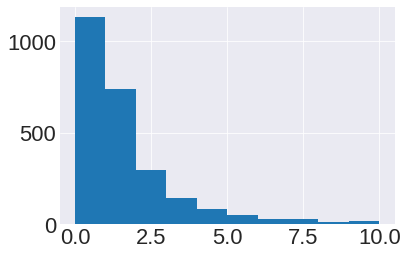

In [59]:
df[df.gross_to_budget_ratio < 10].gross_to_budget_ratio.hist(bins=[0,1,2,3,4,5,6,7,8,9,10]);

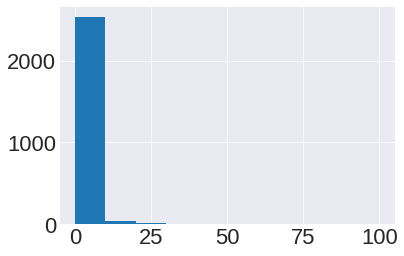

In [60]:
df[df.gross_to_budget_ratio < 100].gross_to_budget_ratio.hist(bins=[0,10,20,30,40,50,60,70,80,90,100]);

In [61]:
less_than_1 = len(df[df.gross_to_budget_ratio < 1]) / len(df)
less_than_2 = len(df[df.gross_to_budget_ratio < 2]) / len(df)
less_than_10 = len(df[df.gross_to_budget_ratio < 10]) / len(df)
(less_than_1, (less_than_2 - less_than_1), (less_than_10 - less_than_2), (1 - less_than_10))

(0.4345489443378119,
 0.28291746641074855,
 0.253358925143954,
 0.029174664107485593)

In [62]:
df.gross_to_budget_ratio.median()

1.1673481388888889

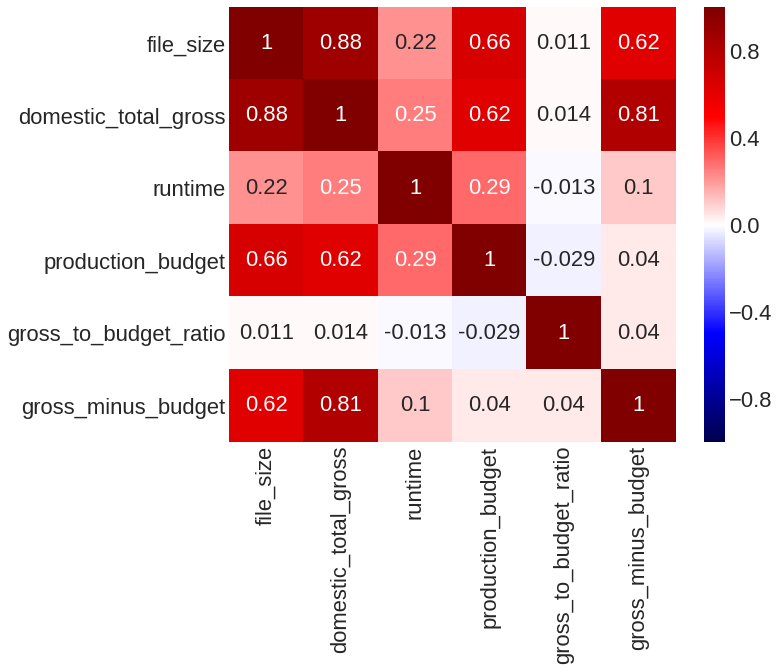

In [63]:
feature_columns = ['file_size','domestic_total_gross','release_date','runtime',
                   'production_budget','gross_to_budget_ratio','gross_minus_budget']
features = df[feature_columns]
plt.figure(figsize=(10,8))
sns.heatmap(features.corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);

In [29]:
median_budget = df.production_budget.median()
print(median_budget)
avg_ratio_for_big_budget = df[df.production_budget > median_budget].gross_to_budget_ratio.mean()
avg_ratio_for_small_budget = df[df.production_budget < median_budget].gross_to_budget_ratio.mean()
# Small budget films have greater ROI
(avg_ratio_for_small_budget, avg_ratio_for_big_budget)

35000000.0


(9.26685410943, 1.2011132609548412)

In [235]:
dates = []
rolling_avg_ratios = []
min_start_date = df.release_date.min()
max_end_date = df.release_date.max()
# start_date = min_start_date
start_date = dt.date(1999, 1, 1)
end_date = max_end_date
days_between = (end_date - start_date).days
not_paranormal = (df.name != 'paranormalactivity')
for day in range(days_between):
    if end_date > max_end_date: break
    start_date += dt.timedelta(days=1)
    end_date = start_date + dt.timedelta(days=365*10)
    avg_ratio = df[not_paranormal & (df.release_date >= start_date) & (df.release_date < end_date)].gross_to_budget_ratio.mean()
    dates.append(end_date)
    rolling_avg_ratios.append(avg_ratio)

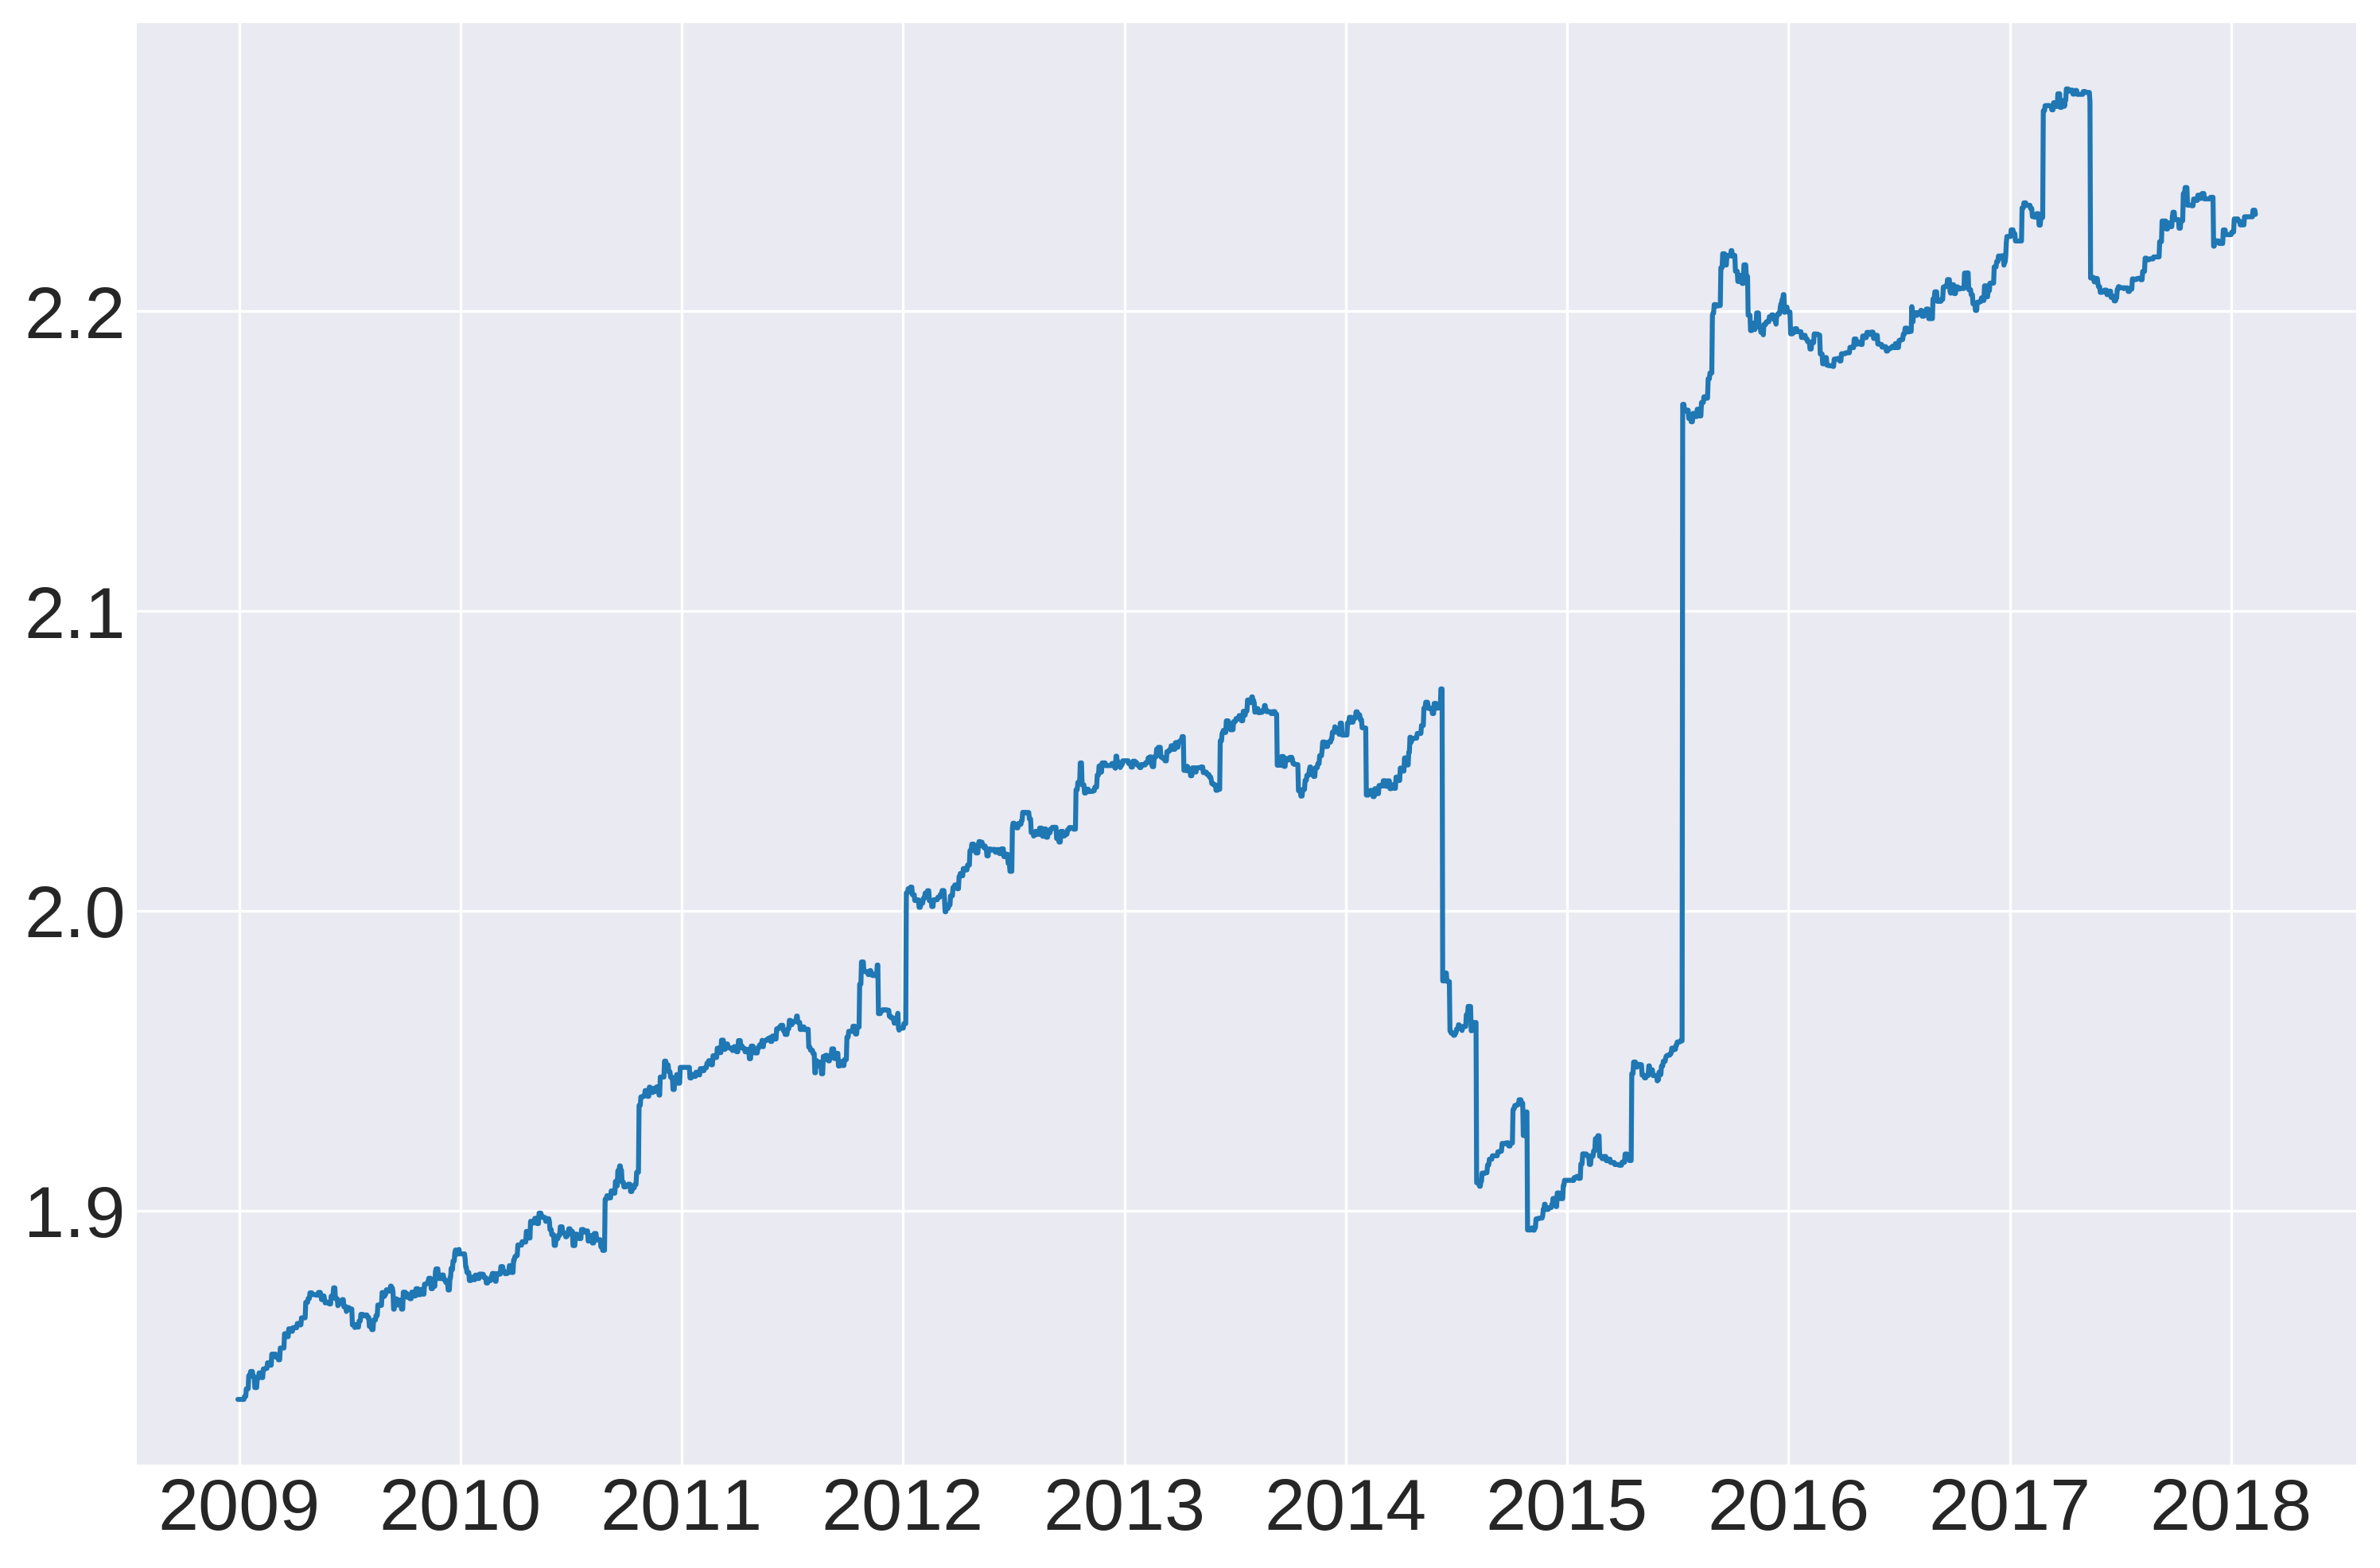

In [237]:
plt.figure(figsize=(12,8), dpi=300)
# plt.axvline(dt.date(1999, 1, 1), linestyle='dashed', c='black')
plt.plot(dates, rolling_avg_ratios);

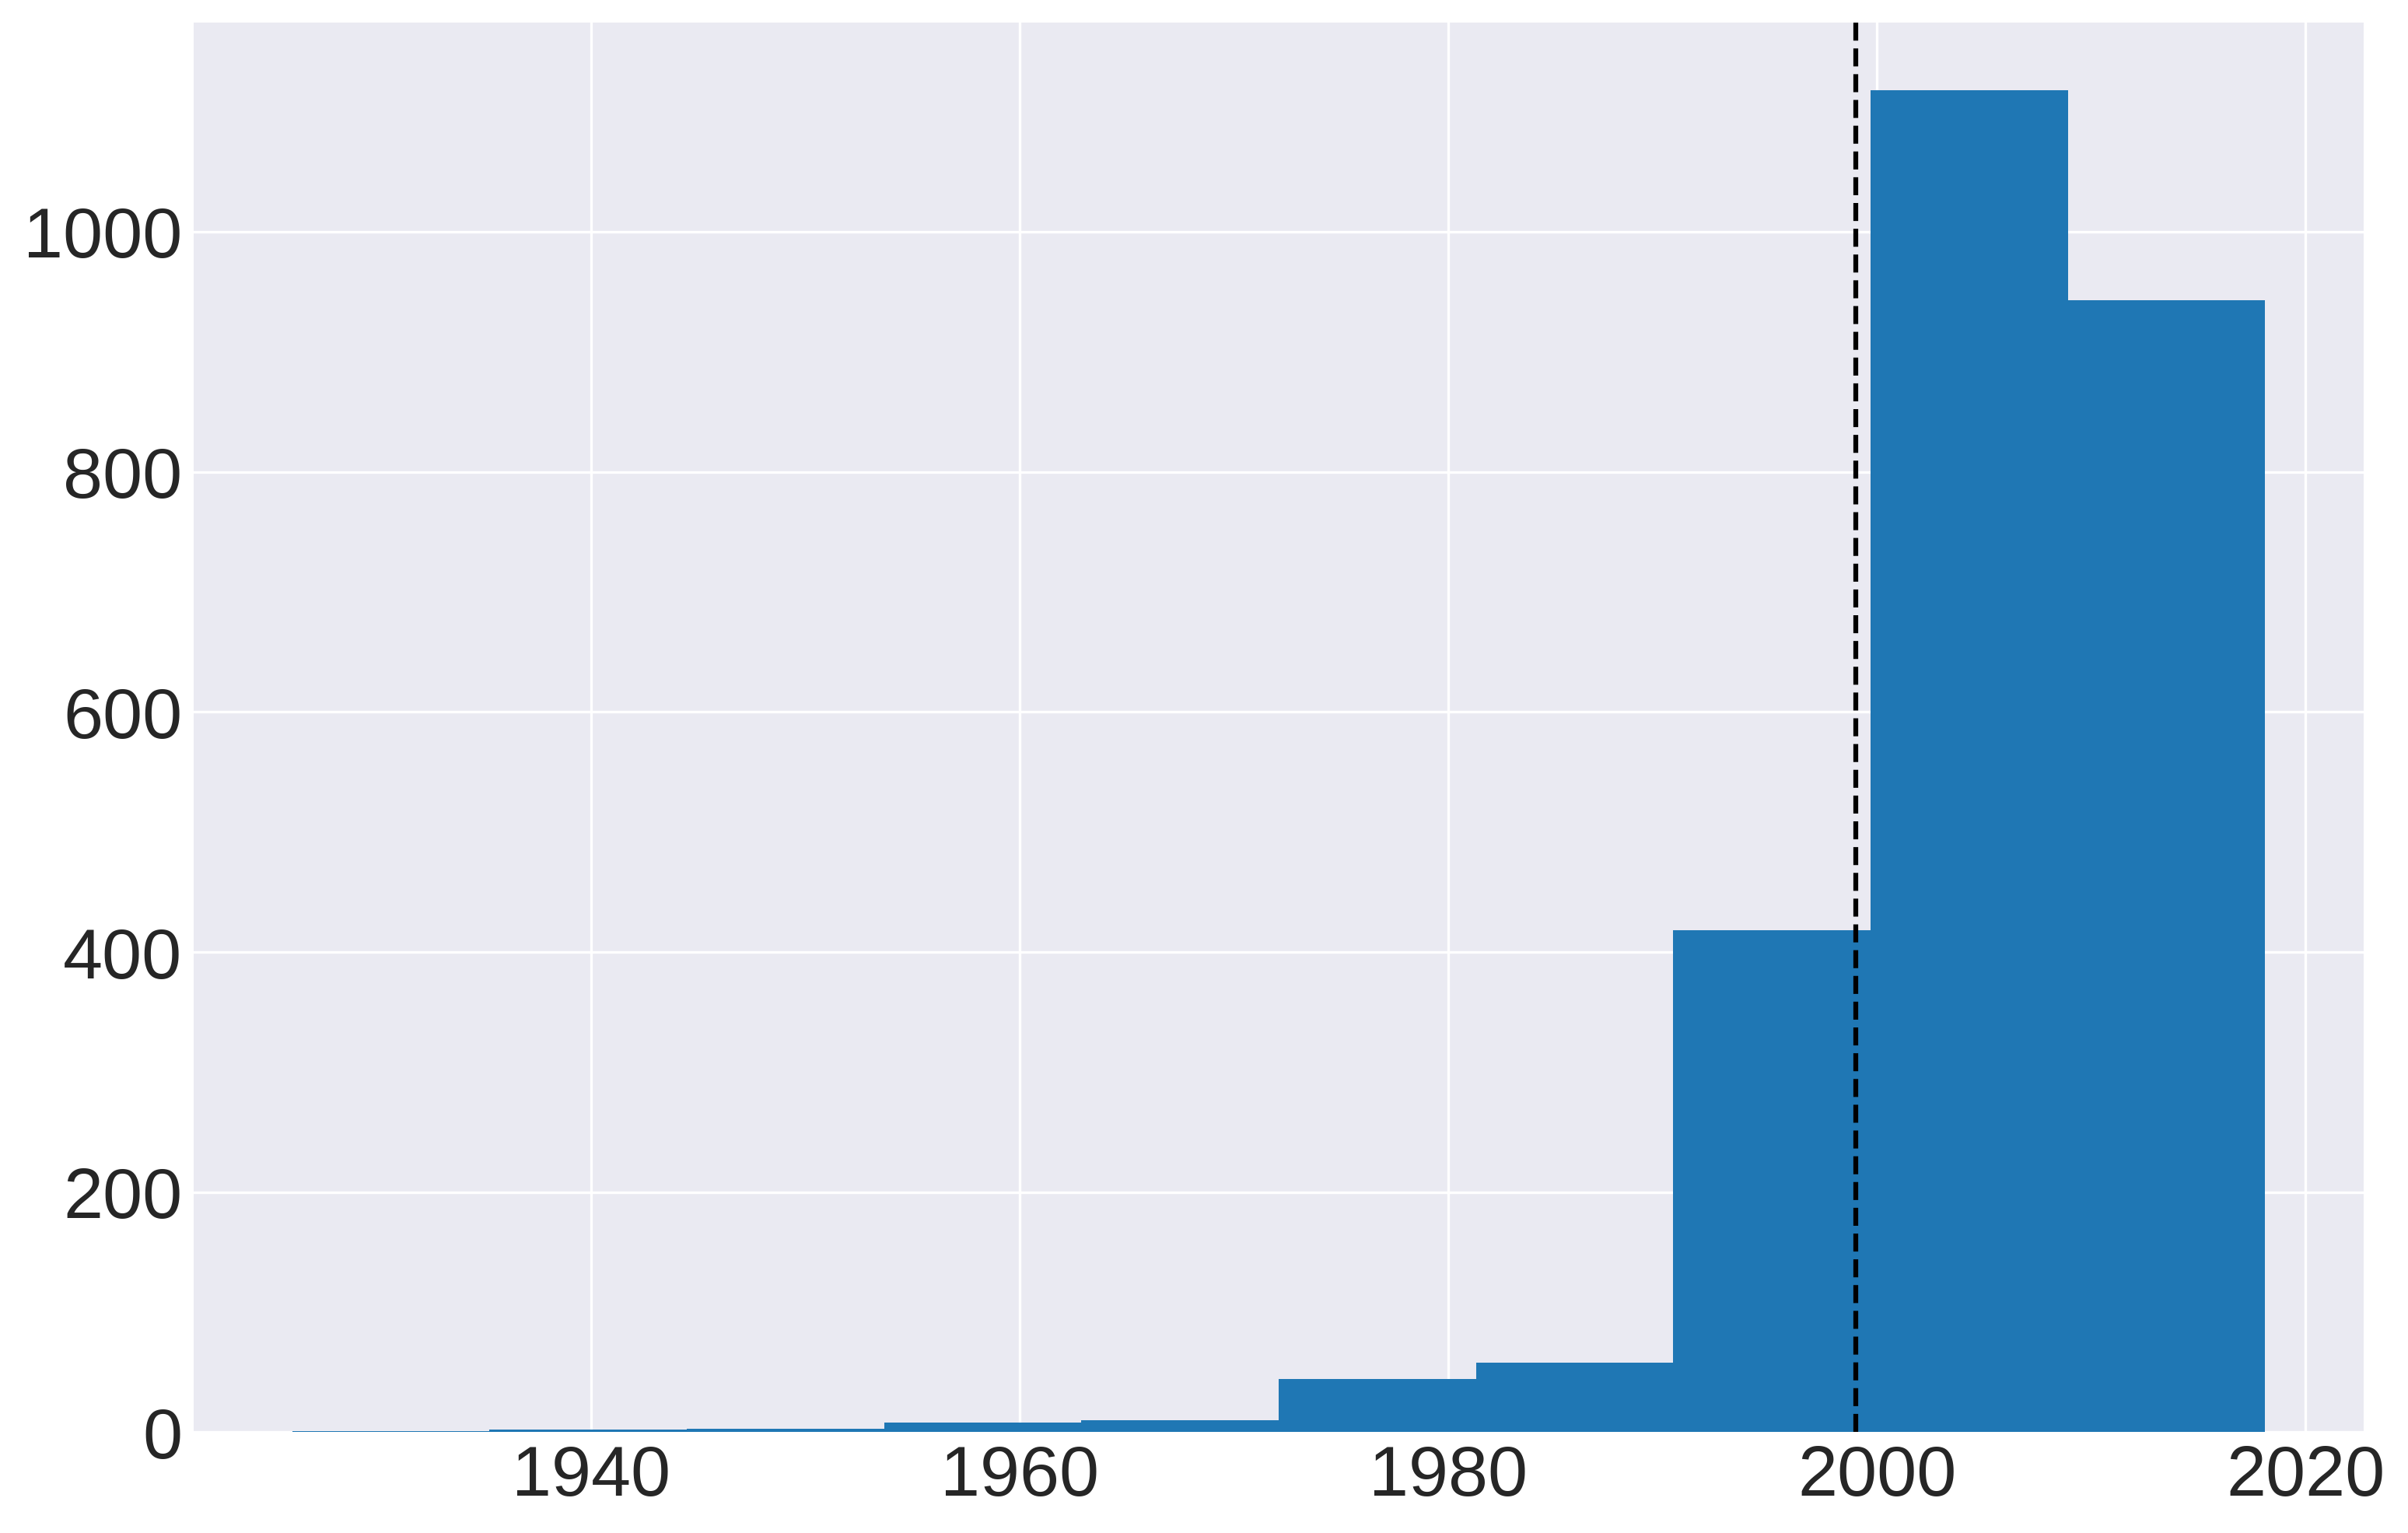

In [66]:
plt.figure(figsize=(12,8), dpi=300)
plt.axvline(dt.date(1999, 1, 1), linestyle='dashed', c='black')
df.release_date.hist();

In [67]:
recent_df = df[df.release_date > dt.date(1999, 1, 1)]
recent_df.describe()

,file_size,domestic_total_gross,runtime,production_budget,gross_to_budget_ratio,gross_minus_budget
count,2150.000000,2.150000e+03,2147.000000,2.150000e+03,2150.000000,2.150000e+03
mean,26750.146512,6.947414e+07,108.721938,5.362305e+07,5.387712,1.585110e+07
std,5764.346307,8.051436e+07,18.391150,4.885700e+07,155.251483,6.074153e+07
min,17930.000000,1.667000e+04,63.000000,1.500000e+04,0.000840,-1.769219e+08
25%,23383.500000,1.929526e+07,95.000000,2.000000e+07,0.590140,-1.399704e+07
50%,25227.000000,4.319685e+07,106.000000,3.650000e+07,1.139873,3.995397e+06
75%,28148.750000,8.820261e+07,120.000000,7.475000e+07,2.034766,3.298077e+07
max,63865.000000,9.366622e+08,210.000000,3.000000e+08,7194.587333,6.916622e+08


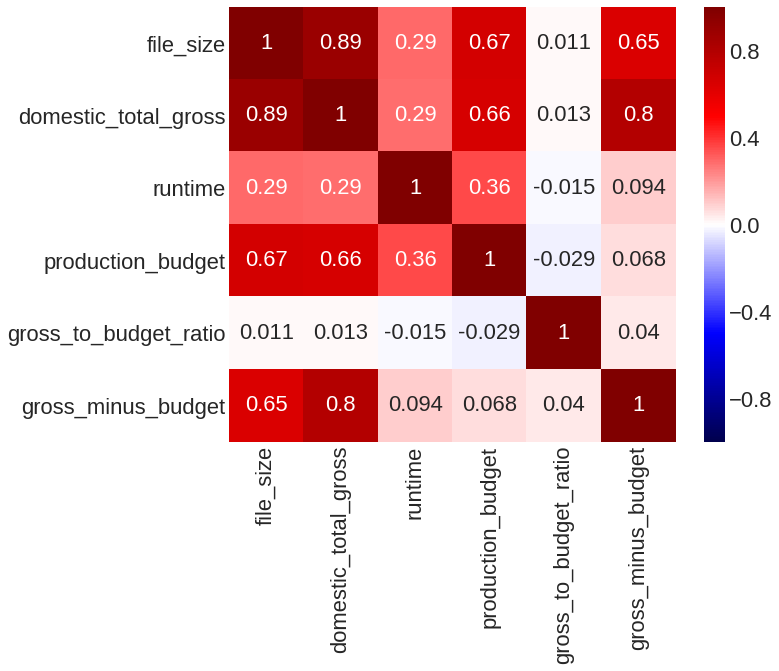

In [68]:
plt.figure(figsize=(10,8))
sns.heatmap(recent_df[feature_columns].corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);

In [74]:
recent_df.sort_values('gross_to_budget_ratio', ascending=False).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
4348,paranormalactivity,http://www.boxofficemojo.com/movies/?id=parano...,29252,107918810.0,Paramount,2009-09-25,Horror,99.0,R,15000.0,7194.587333,107903810.0
3625,newlinehorror2015,http://www.boxofficemojo.com/movies/?id=newlin...,21824,22764410.0,Warner Bros. (New Line),2015-07-10,Horror,81.0,R,100000.0,227.644100,22664410.0
4487,napoleondynamite,http://www.boxofficemojo.com/movies/?id=napole...,26884,44540956.0,Fox Searchlight,2004-06-11,Comedy,86.0,PG,400000.0,111.352390,44140956.0
5224,once,http://www.boxofficemojo.com/movies/?id=once.htm,20173,9439923.0,Fox Searchlight,2007-05-16,Music Drama,85.0,R,150000.0,62.932820,9289923.0
2743,openwater,http://www.boxofficemojo.com/movies/?id=openwa...,25403,30610863.0,Lions Gate,2004-08-06,Horror,79.0,R,500000.0,61.221726,30110863.0
6622,devilinside,http://www.boxofficemojo.com/movies/?id=devili...,26185,53261944.0,Paramount,2012-01-06,Horror,87.0,R,1000000.0,53.261944,52261944.0
5704,saw,http://www.boxofficemojo.com/movies/?id=saw.htm,29483,55185045.0,Lions Gate,2004-10-29,Horror,100.0,R,1200000.0,45.987538,53985045.0
6772,blumhouse2,http://www.boxofficemojo.com/movies/?id=blumho...,28639,176040665.0,Universal,2017-02-24,Horror,103.0,R,4500000.0,39.120148,171540665.0
2263,cybernatural,http://www.boxofficemojo.com/movies/?id=cybern...,23531,32482090.0,Universal,2015-04-17,Horror,83.0,R,1000000.0,32.482090,31482090.0
2245,paranormalactivity2,http://www.boxofficemojo.com/movies/?id=parano...,30161,84752907.0,Paramount,2010-10-22,Horror,91.0,R,3000000.0,28.250969,81752907.0


In [75]:
recent_df.genre.unique()

array(['Comedy', 'Sports Comedy', 'Sci-Fi Action', 'Horror',
       'Romantic Comedy', 'Action / Adventure', 'Foreign', 'Horror Comedy',
       'Adventure', 'Sci-Fi Thriller', 'Animation', 'Crime Drama',
       'Thriller', 'Sci-Fi Comedy', 'Action', 'Comedy Thriller', 'Drama',
       'Comedy / Drama', 'Action Thriller', 'Musical', 'Fantasy',
       'War Drama', 'Sci-Fi', 'Action Horror', 'Music Drama',
       'Action Drama', 'Historical Epic', 'Western', 'Action Comedy',
       'Romance', 'Drama / Thriller', 'Sports Drama', 'War', 'Documentary',
       'Family Adventure', 'Sci-Fi Adventure', 'Fantasy Comedy', 'Unknown',
       'Family Comedy', 'Crime Comedy', 'Horror Thriller', 'Period Horror',
       'Period Drama', 'Family', 'Historical Drama', 'Romantic Thriller',
       'Crime Thriller', 'Foreign / Action', 'Western Comedy',
       'Period Adventure', 'Concert', 'Sci-Fi Horror', 'Fantasy Drama',
       'Action Fantasy', 'Crime', 'Adventure Comedy', 'Sci-Fi Fantasy',
       'Period 

In [99]:
# other_feature_columns = ['release_date','runtime','production_budget']
other_feature_columns = ['runtime','production_budget']
X = pd.get_dummies(recent_df[['genre','mpaa_rating','distributor']])
X[other_feature_columns] = recent_df[other_feature_columns]
# x['release_date'] = X.release_date.apply(lambda rd: ())
X = X.fillna(0)
X.head()
# pd.get_dummies(recent_df[['genre','mpaa_rating','distributor']]).head()

,mpaa_rating_G,mpaa_rating_NC-17,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R,distributor_Buena Vista,distributor_DreamWorks,distributor_Focus Features,distributor_Fox,distributor_Fox Atomic,...,distributor_TriStar,distributor_United Artists,distributor_Universal,distributor_Warner Bros.,distributor_Warner Bros. (New Line),distributor_Warner Independent,distributor_Weinstein / Dimension,distributor_Weinstein Company,runtime,production_budget
6,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,102.0,4000000.0
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,110.0,72500000.0
13,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,120.0,49000000.0
15,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,97.0,10000000.0
16,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,110.0,80000000.0


In [120]:
# y = recent_df['domestic_total_gross']
y = recent_df['gross_to_budget_ratio']

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [123]:
model = ElasticNetCV()
fit = model.fit(X_train, y_train)
fit.score(X_test, y_test)

-0.13445034459400929

In [124]:
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     gross_to_budget_ratio   R-squared:                       0.007
Model:                               OLS   Adj. R-squared:                 -0.010
Method:                    Least Squares   F-statistic:                    0.3957
Date:                   Wed, 25 Apr 2018   Prob (F-statistic):              0.999
Time:                           16:20:16   Log-Likelihood:                -13890.
No. Observations:                   2150   AIC:                         2.785e+04
Df Residuals:                       2114   BIC:                         2.806e+04
Df Model:                             35                                         
Covariance Type:               nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
mpaa_rating_G                           6.3560     27.136      0.234      0.815     -46.859      59.571
mpaa_rating_NC-17                      11.7048     71.669      0.163      0.870    -128.845     152.254
mpaa_rating_PG                          9.6199     19.610      0.491      0.624     -28.837      48.077
mpaa_rating_PG-13                       9.6745     20.581      0.470      0.638     -30.686      50.035
mpaa_rating_R                          17.8681     20.829      0.858      0.391     -22.978      58.715
distributor_Buena Vista                 7.8939     15.635      0.505      0.614     -22.767      38.555
distributor_DreamWorks                  2.4024     23.842      0.101      0.920     -44.353      49.158
distributor_Focus Features             -1.9737     24.305     -0.081      0.935     -49.637      45.690
distributor_Fox                         3.9978     13.685      0.292      0.770     -22.839      30.835
distributor_Fox Atomic                 -8.3418    107.567     -0.078      0.938    -219.290     202.606
distributor_Fox Searchlight            -0.0975     21.099     -0.005      0.996     -41.474      41.279
distributor_Lions Gate                  0.7363     30.273      0.024      0.981     -58.632      60.105
distributor_Lionsgate                  -0.2963     20.291     -0.015      0.988     -40.088      39.496
distributor_Lionsgate Premiere         -9.4858    151.813     -0.062      0.950    -307.204     288.232
distributor_Lionsgate/Summit            5.7243     36.220      0.158      0.874     -65.306      76.755
distributor_MGM                         0.3166     23.004      0.014      0.989     -44.796      45.429
distributor_MGM (Weinstein)            -1.0508     62.521     -0.017      0.987    -123.661     121.559
distributor_Miramax                    -1.3677     20.307     -0.067      0.946     -41.192      38.456
distributor_New Line                   -0.1260     20.000     -0.006      0.995     -39.349      39.096
distributor_Paramount                  40.7096     14.559      2.796      0.005      12.158      69.261
distributor_Paramount (DreamWorks)      8.2989     29.764      0.279      0.780     -50.072      66.670
distributor_Paramount Classics         -4.9974     76.340     -0.065      0.948    -154.706     144.711
distributor_Sony (Revolution)           3.1755     30.665      0.104      0.918     -56.961      63.312
distributor_Sony / Columbia             3.5169     14.221      0.247      0.805     -24.372      31.406
distributor_Sony / Screen Gems         -1.1750     20.916     -0.056      0.955     -42.193      39.843
distributor_Sony Classics              -3.6793     23.614     -0.156      0.876     -49.988      42.629
distributor_Sony Repertory        

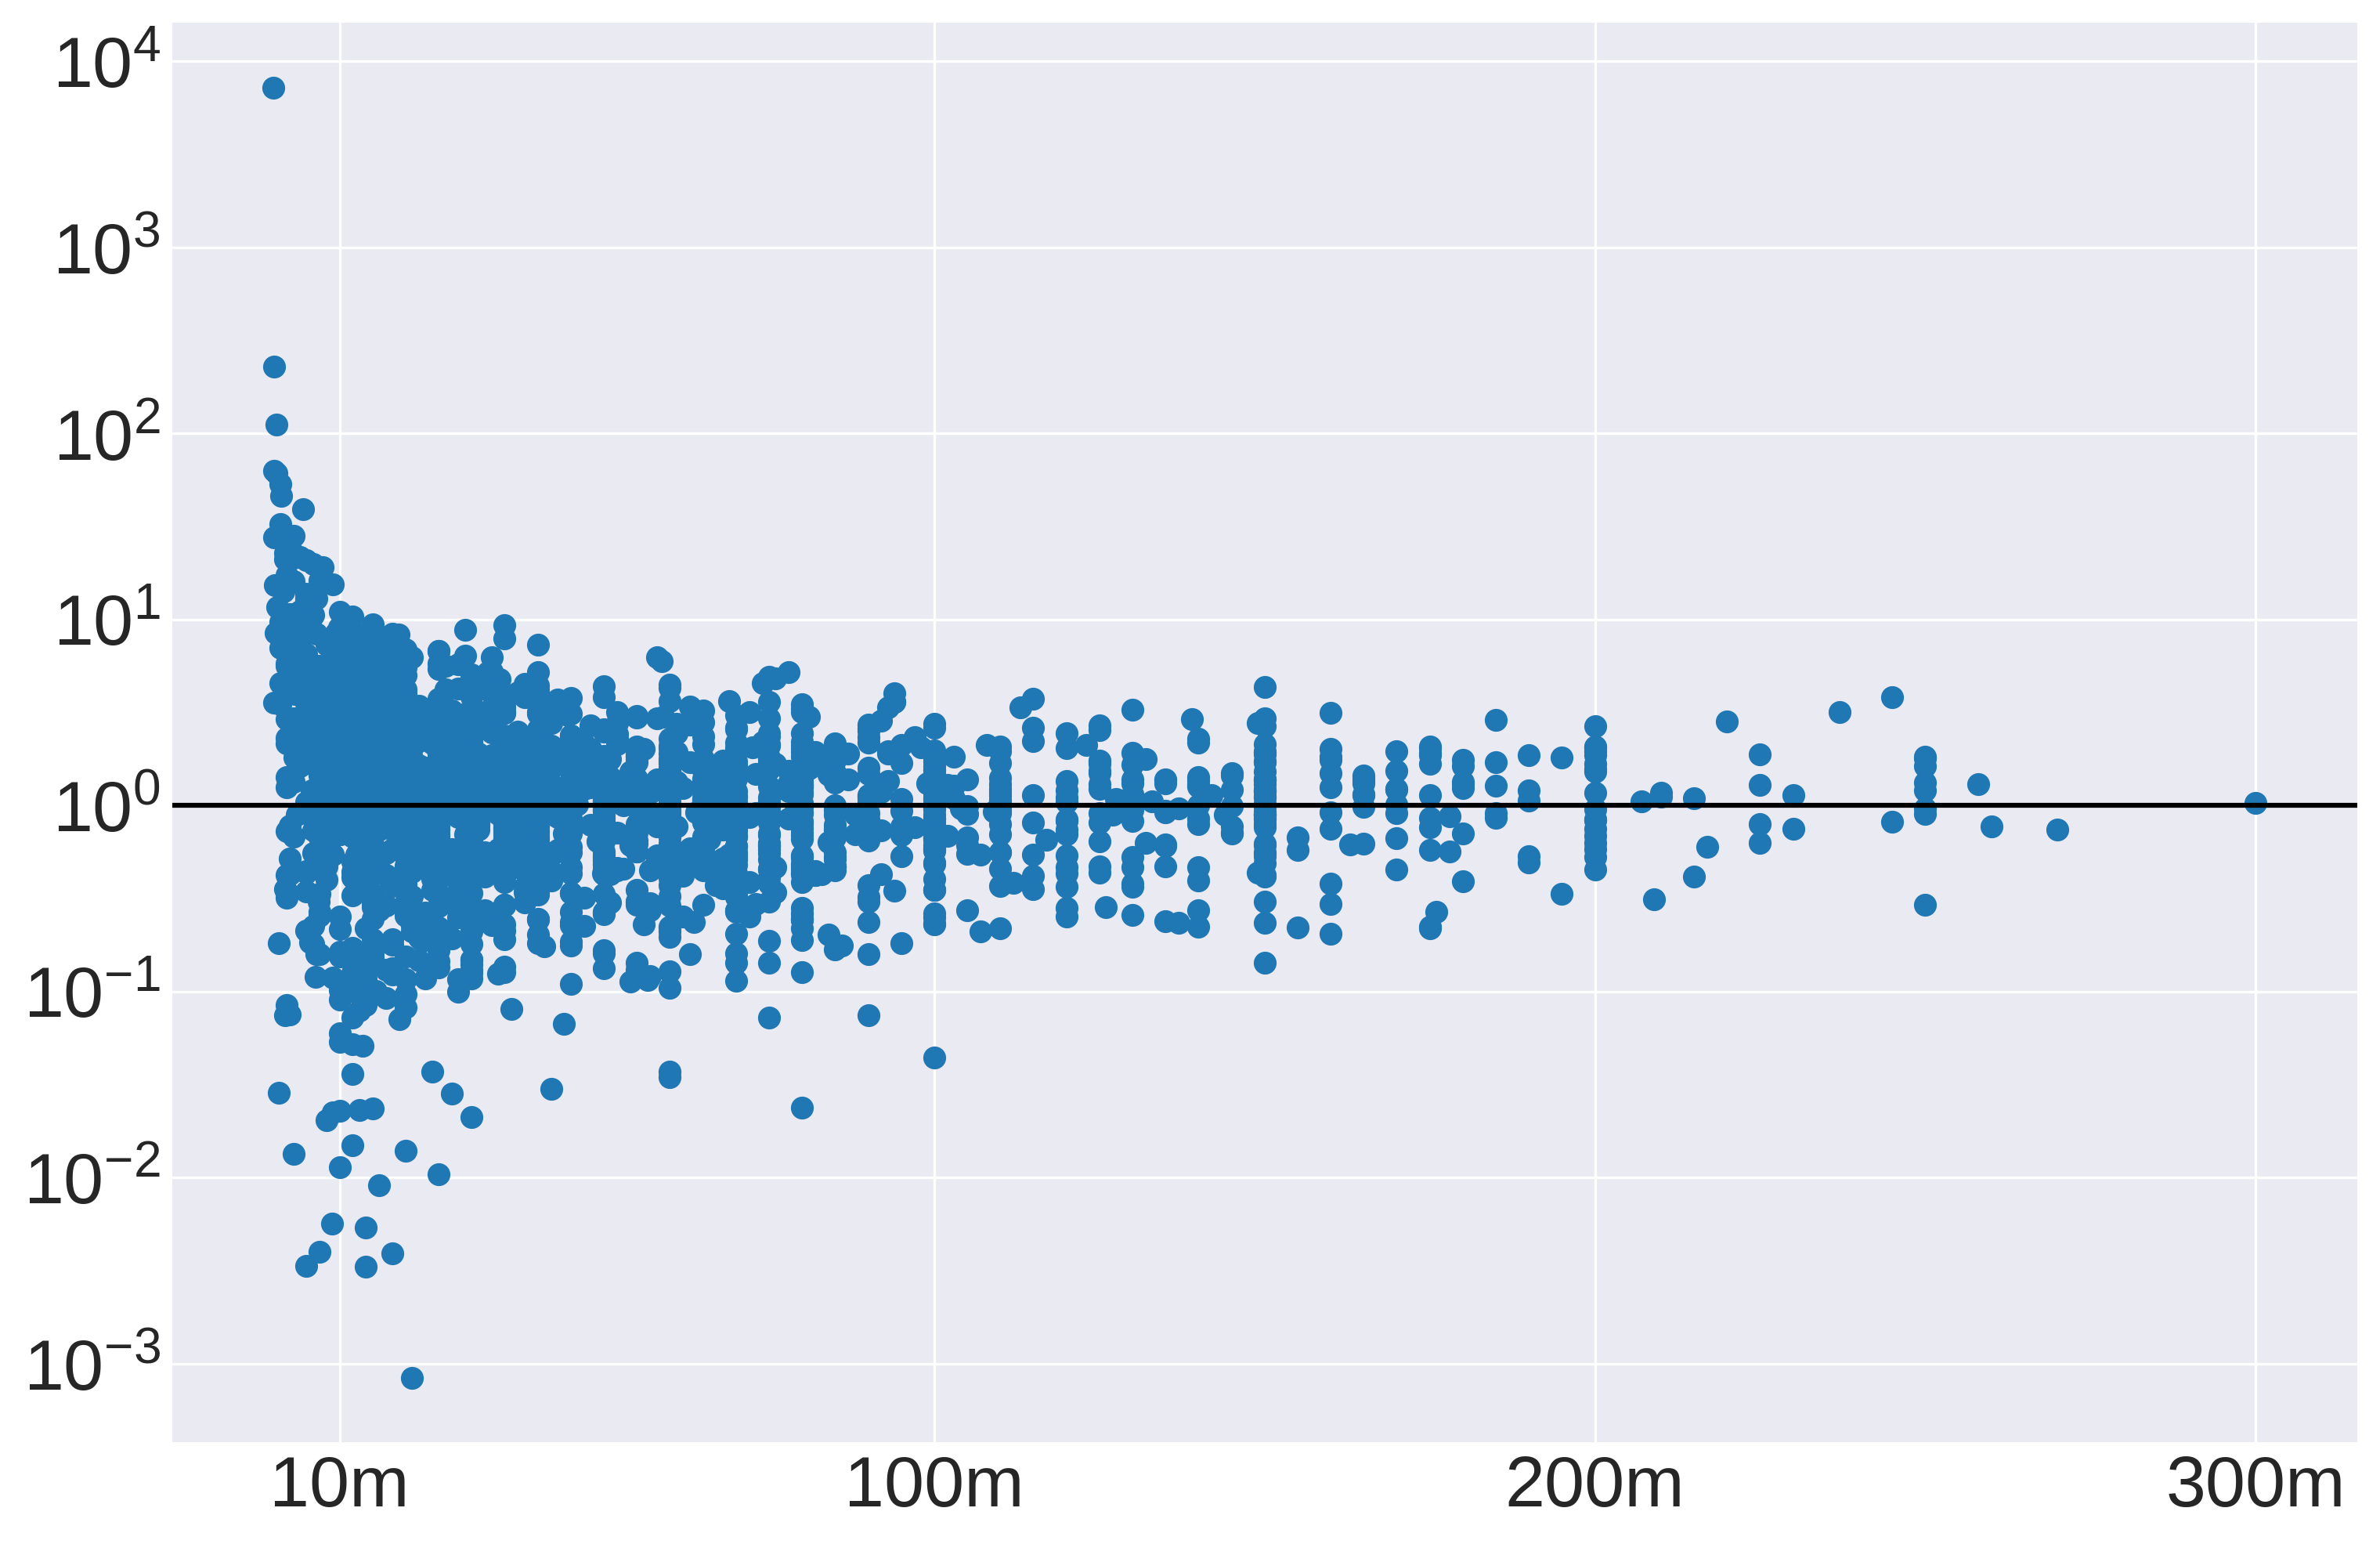

In [234]:
plt.figure(figsize=(12,8), dpi=300)
plt.yscale('log')
plt.axhline(1, linestyle='solid', c='black')
plt.xticks([1e7,1e8,2e8,3e8], ['10m', '100m', '200m', '300m'])
plt.scatter(recent_df.production_budget, recent_df.gross_to_budget_ratio, alpha=1);
# only_horror = recent_df[recent_df.genre == 'Horror']
# plt.scatter(only_horror.production_budget, only_horror.gross_to_budget_ratio);
# only_paramount = recent_df[recent_df.distributor == 'Paramount']
# plt.scatter(only_paramount.production_budget, only_paramount.gross_to_budget_ratio);

# rdf = recent_df[recent_df.release_date > dt.date(2010, 1, 1)]
# plt.scatter(rdf.production_budget, rdf.gross_to_budget_ratio, alpha=1);

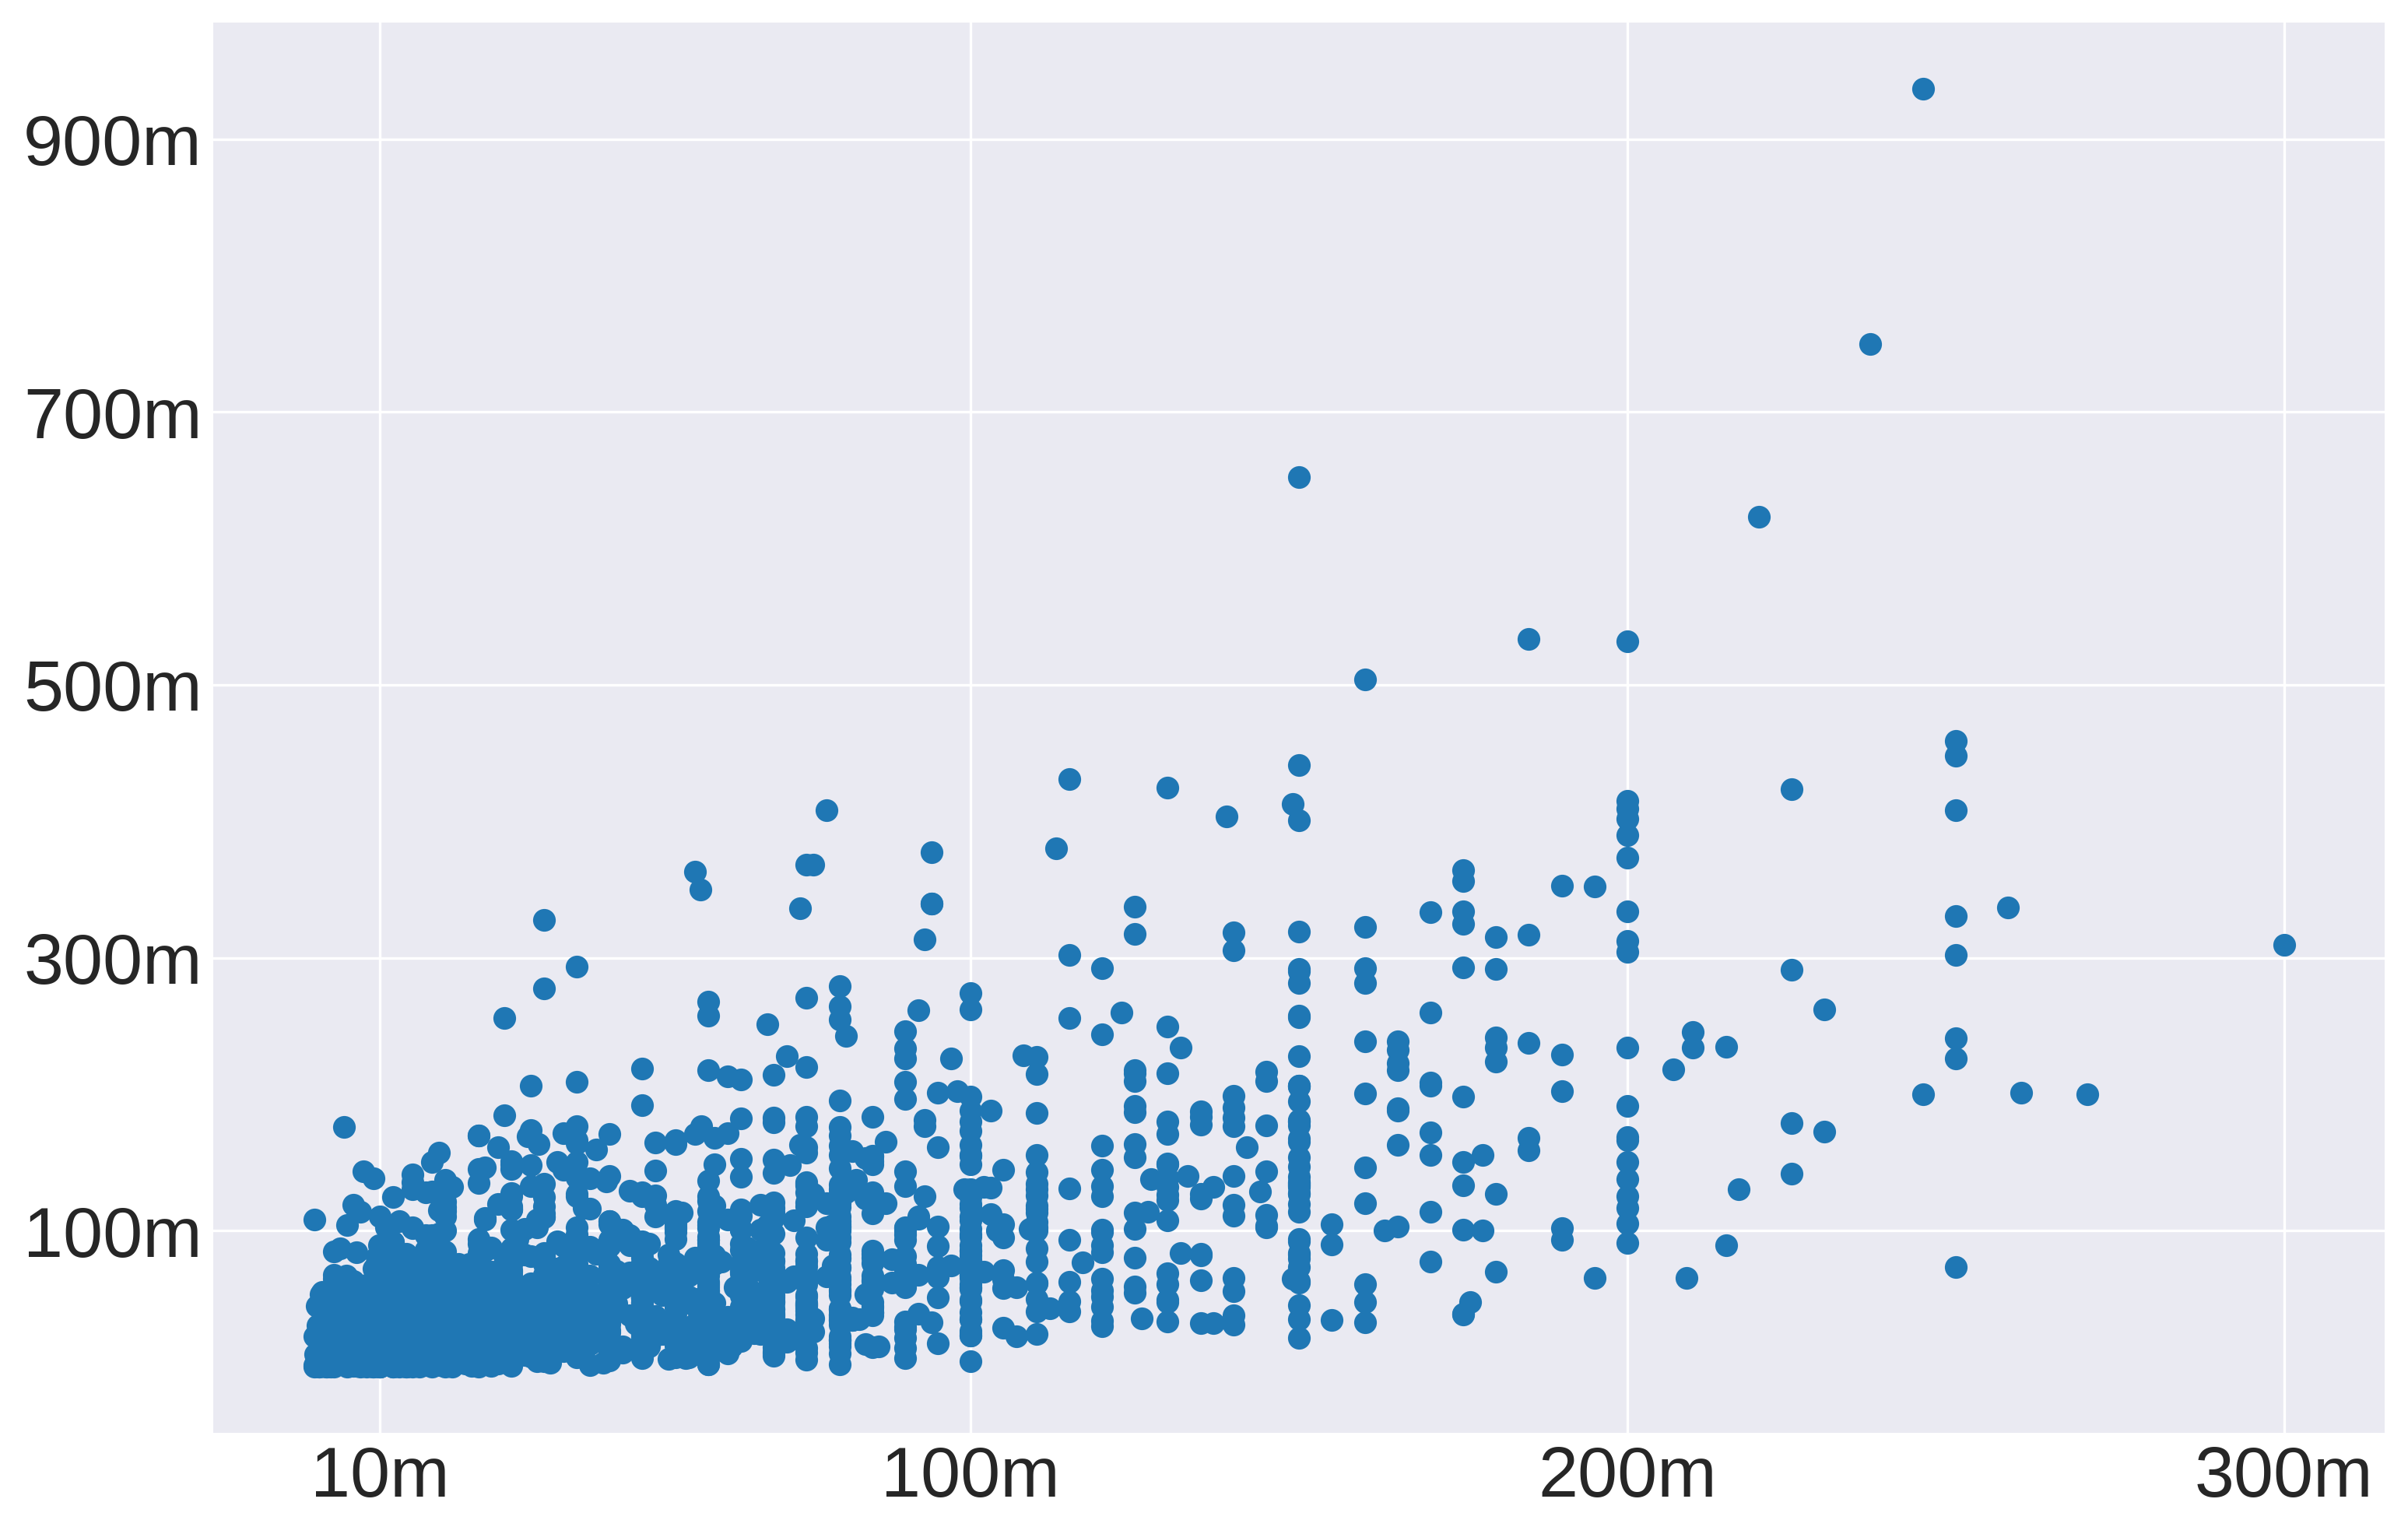

In [146]:
plt.figure(figsize=(12,8), dpi=300)
plt.xticks([1e7,1e8,2e8,3e8], ['10m', '100m', '200m', '300m'])
plt.yticks([1e8,3e8, 5e8, 7e8, 9e8], ['100m', '300m', '500m', '700m', '900m'])
plt.scatter(recent_df.production_budget, recent_df.domestic_total_gross);

In [139]:
recent_df[recent_df.production_budget > 2.9e8]

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
3225,piratesofthecaribbean3,http://www.boxofficemojo.com/movies/?id=pirate...,44426,309420425.0,Buena Vista,2007-05-25,Period Adventure,168.0,PG-13,300000000.0,1.031401,9420425.0


In [229]:
# only_horror[only_horror.name != 'paranormalactivity'].gross_to_budget_ratio.mean()
only_horror.gross_to_budget_ratio.median()

2.2109270625

In [170]:
recent_df.release_date.max()

datetime.date(2018, 2, 9)

In [230]:
# recent_df[recent_df.name != 'paranormalactivity'].gross_to_budget_ratio.mean()
recent_df.gross_to_budget_ratio.median()

1.1398728372727271

In [174]:
recent_df['is_horror'] = (recent_df.genre == 'Horror').astype(float)
recent_df.head()

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget,is_horror
6,lostintranslation,http://www.boxofficemojo.com/movies/?id=lostin...,26272,44585453.0,Focus Features,2003-09-12,Comedy,102.0,R,4000000.0,11.146363,40585453.0,0.0
10,talladeganights,http://www.boxofficemojo.com/movies/?id=tallad...,32496,148213377.0,Sony / Columbia,2006-08-04,Sports Comedy,110.0,PG-13,72500000.0,2.044322,75713377.0,0.0
13,chappie,http://www.boxofficemojo.com/movies/?id=chappi...,25637,31569268.0,Sony / Columbia,2015-03-06,Sci-Fi Action,120.0,R,49000000.0,0.644271,-17430732.0,0.0
15,insidiouschapter3,http://www.boxofficemojo.com/movies/?id=insidi...,24296,52218558.0,Focus Features,2015-06-05,Horror,97.0,PG-13,10000000.0,5.221856,42218558.0,1.0
16,thepretendwife,http://www.boxofficemojo.com/movies/?id=thepre...,30490,103028109.0,Sony / Columbia,2011-02-11,Romantic Comedy,110.0,PG-13,80000000.0,1.287851,23028109.0,0.0


In [178]:
recent_df['log_roi'] = recent_df.gross_to_budget_ratio.apply(np.log)

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [180]:
features_with_log_roi_df = X.copy()
features_with_log_roi_df['log_roi'] = recent_df.log_roi

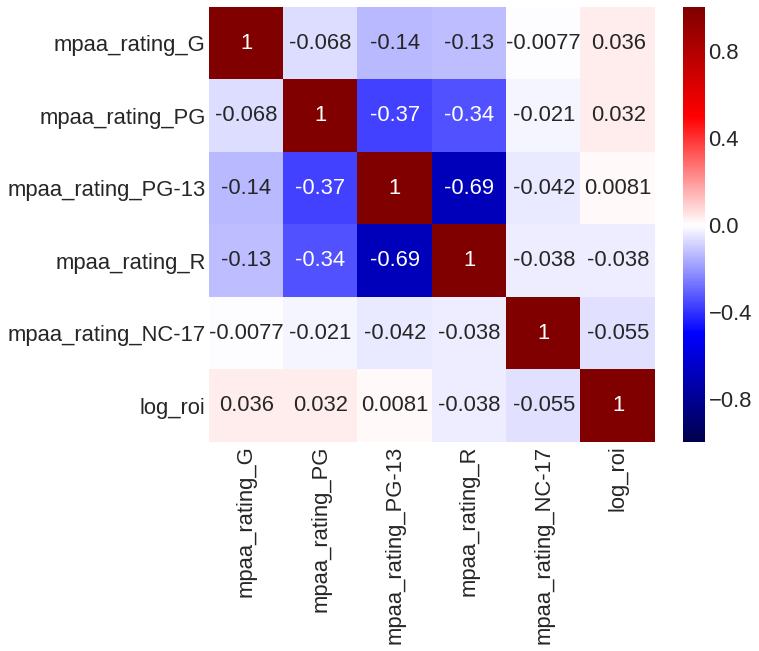

In [200]:
plt.figure(figsize=(10,8))
column_names = ['mpaa_rating_G','mpaa_rating_PG','mpaa_rating_PG-13','mpaa_rating_R','mpaa_rating_NC-17', 'log_roi']
sns.heatmap(features_with_log_roi_df[column_names].corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);
# sns.heatmap(recent_df.corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);

In [202]:
features_with_log_roi_df.corr().loc['log_roi']

mpaa_rating_G                          0.036422
mpaa_rating_NC-17                     -0.054993
mpaa_rating_PG                         0.031812
mpaa_rating_PG-13                      0.008107
mpaa_rating_R                         -0.038096
distributor_Buena Vista               -0.002835
distributor_DreamWorks                -0.026060
distributor_Focus Features             0.014236
distributor_Fox                        0.014619
distributor_Fox Atomic                -0.002159
distributor_Fox Searchlight            0.043987
distributor_Lions Gate                 0.058655
distributor_Lionsgate                  0.040499
distributor_Lionsgate Premiere        -0.100130
distributor_Lionsgate/Summit           0.004259
distributor_MGM                       -0.073345
distributor_MGM (Weinstein)            0.005320
distributor_Miramax                   -0.100148
distributor_New Line                  -0.026264
distributor_Paramount                  0.050633
distributor_Paramount (DreamWorks)    -0

In [187]:
y = recent_df.log_roi
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_roi   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     7.199
Date:                Thu, 26 Apr 2018   Prob (F-statistic):           2.21e-32
Time:                        13:11:08   Log-Likelihood:                -3192.9
No. Observations:                2150   AIC:                             6458.
Df Residuals:                    2114   BIC:                             6662.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
mpaa_rating_G                           0.1662      0.187      0.887      0.375      -0.201       0.534
mpaa_rating_NC-17                      -1.3531      0.495     -2.734      0.006      -2.324      -0.383
mpaa_rating_PG                         -0.0399      0.135     -0.295      0.768      -0.305       0.226
mpaa_rating_PG-13                      -0.1719      0.142     -1.210      0.226      -0.451       0.107
mpaa_rating_R                          -0.3356      0.144     -2.333      0.020      -0.618      -0.054
distributor_Buena Vista                 0.1285      0.108      1.191      0.234      -0.083       0.340
distributor_DreamWorks                 -0.1022      0.165     -0.621      0.535      -0.425       0.221
distributor_Focus Features              0.1712      0.168      1.020      0.308      -0.158       0.500
distributor_Fox                         0.1585      0.095      1.677      0.094      -0.027       0.344
distributor_Fox Atomic                  0.0599      0.743      0.081      0.936      -1.397       1.517
distributor_Fox Searchlight             0.3279      0.146      2.250      0.025       0.042       0.614
distributor_Lions Gate                  0.6398      0.209      3.061      0.002       0.230       1.050
distributor_Lionsgate                   0.3418      0.140      2.439      0.015       0.067       0.617
distributor_Lionsgate Premiere         -5.1300      1.048     -4.893      0.000      -7.186      -3.074
distributor_Lionsgate/Summit            0.2056      0.250      0.822      0.411      -0.285       0.696
distributor_MGM                        -0.4546      0.159     -2.861      0.004      -0.766      -0.143
distributor_MGM (Weinstein)             0.1847      0.432      0.428      0.669      -0.662       1.031
distributor_Miramax                    -0.5613      0.140     -4.003      0.000      -0.836      -0.286
distributor_New Line                   -0.0594      0.138     -0.430      0.667      -0.330       0.211
distributor_Paramount                   0.3274      0.101      3.256      0.001       0.130       0.525
distributor_Paramount (DreamWorks)      0.2441      0.206      1.188      0.235      -0.159       0.647
distributor_Paramount Classics         -1.2521      0.527     -2.375      0.018      -2.286      -0.218
distributor_Sony (Revolution)           0.2346      0.212      1.108      0.268      -0.181       0.650
distributor_Sony / Columbia             0.0589      0.098      0.600      0.549      -0.134       0.251
distributor_Sony / Screen Gems          0.3330      0.144      2.305      0.021       0.050       0.616
distributor_Sony Classics              -0.9679      0.163     -5.935      0.000      -1.288      -0.648
distributor_Sony Repertory              1.0019      1.050      0.95

In [191]:
from sklearn.metrics import mean_squared_error

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = ElasticNetCV()
model.fit(X_train, y_train)

mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

1.3460457234249095

In [228]:
def predict(features):
    return np.zeros(features.shape[0])

mean_squared_error(y_true=y_test, y_pred=predict(X_test))

1.3867271911419283